# figure generations
loading both tensorboard and generating confusion matrices

## Experiment 1
train on CN, test on EN

In [1]:
import json
import os
import numpy as np
import seaborn as sb
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

parent_dir = '2024_02_22'

In [2]:
#everything except the confusion matrix
def print_metrics(json_dict):
    for key, metric in json_dict.items():
        if key != 'confusion_matrix':
            print(key, ": ", metric)

In [3]:
exp_1_fp = os.path.join(parent_dir, 'experiment_1_eval.json')
with open(exp_1_fp) as file:
    exp_1_json = json.load(file)

exp_1_json

{'loss': 2.4255006313323975,
 'categorical_accuracy': 0.3654504716396332,
 'precision': 0.5248971581459045,
 'recall': 0.2658788561820984,
 'top_1_categorical_accuracy': 0.3654504716396332,
 'top_10_categorical_accuracy': 0.8650497794151306,
 'top_3_categorical_accuracy': 0.6087295413017273,
 'top_5_categorical_accuracy': 0.7261362075805664,
 'confusion_matrix': [[875,
   0,
   0,
   0,
   0,
   4,
   0,
   0,
   0,
   0,
   36,
   10,
   0,
   1,
   0,
   0,
   0,
   0,
   22,
   0,
   7,
   9,
   0,
   66,
   11,
   0,
   33,
   15,
   13,
   17,
   11,
   0,
   4,
   0,
   0,
   14,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   6,
   0,
   0,
   0,
   0,
   0,
   1,
   6,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   11,
   3,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   3,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0

In [4]:
print_metrics(exp_1_json)

loss :  2.4255006313323975
categorical_accuracy :  0.3654504716396332
precision :  0.5248971581459045
recall :  0.2658788561820984
top_1_categorical_accuracy :  0.3654504716396332
top_10_categorical_accuracy :  0.8650497794151306
top_3_categorical_accuracy :  0.6087295413017273
top_5_categorical_accuracy :  0.7261362075805664


In [5]:
exp_1_mat = np.array(exp_1_json['confusion_matrix'])
exp_1_mat.shape

(105, 105)

<Axes: >

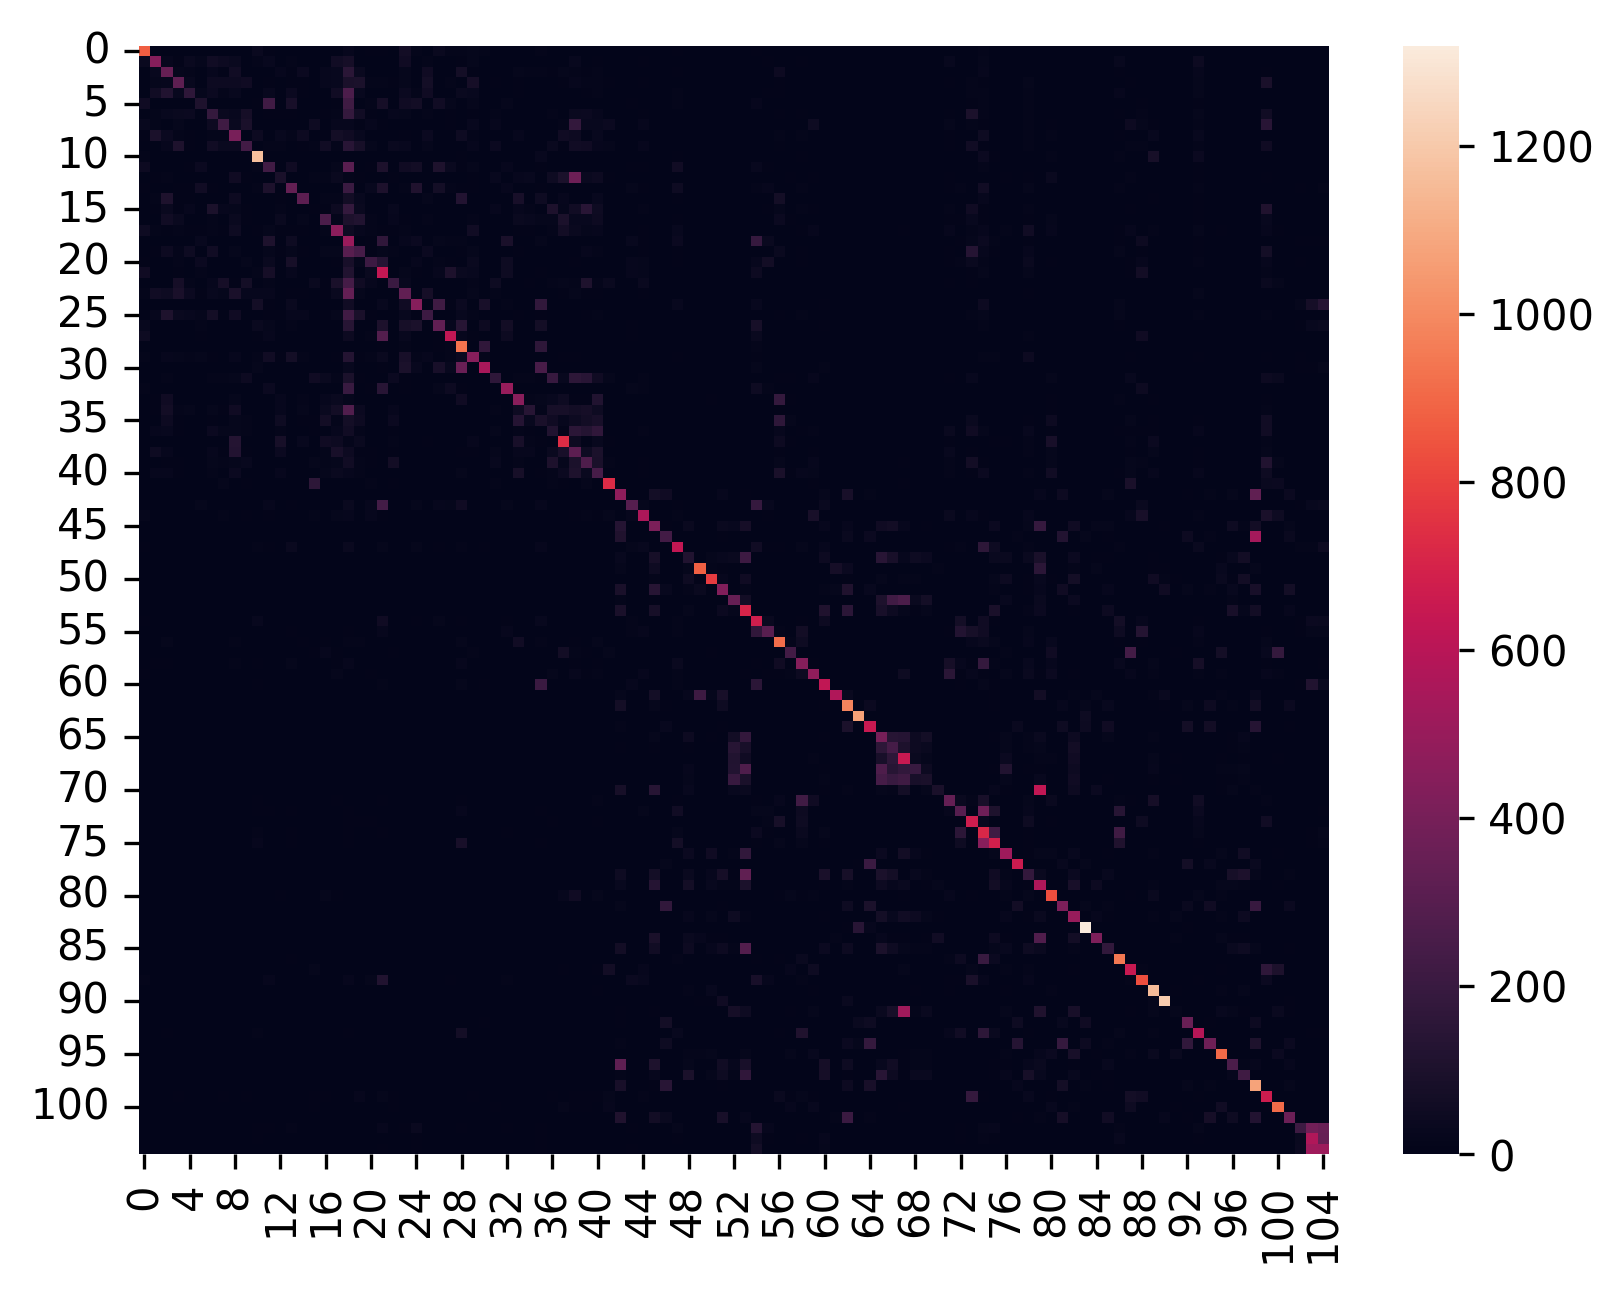

In [6]:
sb.heatmap(exp_1_mat)

## Misc

### CERUG CN-EN distributions

In [7]:
from pathlib import Path
import pandas as pd

#for structure of dataset/writer/scriptname/files
def file_df(dir: str):
    files = Path(dir).rglob('*.*')
    df = pd.DataFrame([x for x in files], columns=['files'])
    df['class'] = df['files'].apply(lambda x: x.parent.parent.name)

    return df


In [8]:
dir = "../prepared datasets/CERUG_prepped_02-14-2024/CERUG"

In [9]:
import os
cn_df = file_df(os.path.join(dir, 'CN'))
labels_cn = cn_df['class'].unique()
counts_cn = cn_df['class'].value_counts(sort=None)

In [10]:
en_df = file_df(os.path.join(dir, 'EN'))
labels_en = en_df['class'].unique() #should be the same
counts_en = en_df['class'].value_counts(sort=None)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def plot_distributions(ax, value_counts, name):
    sns.barplot(data = value_counts, ax=ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel("")
    ax.set_xlabel(name)
    ax.tick_params(left=False, bottom=False)

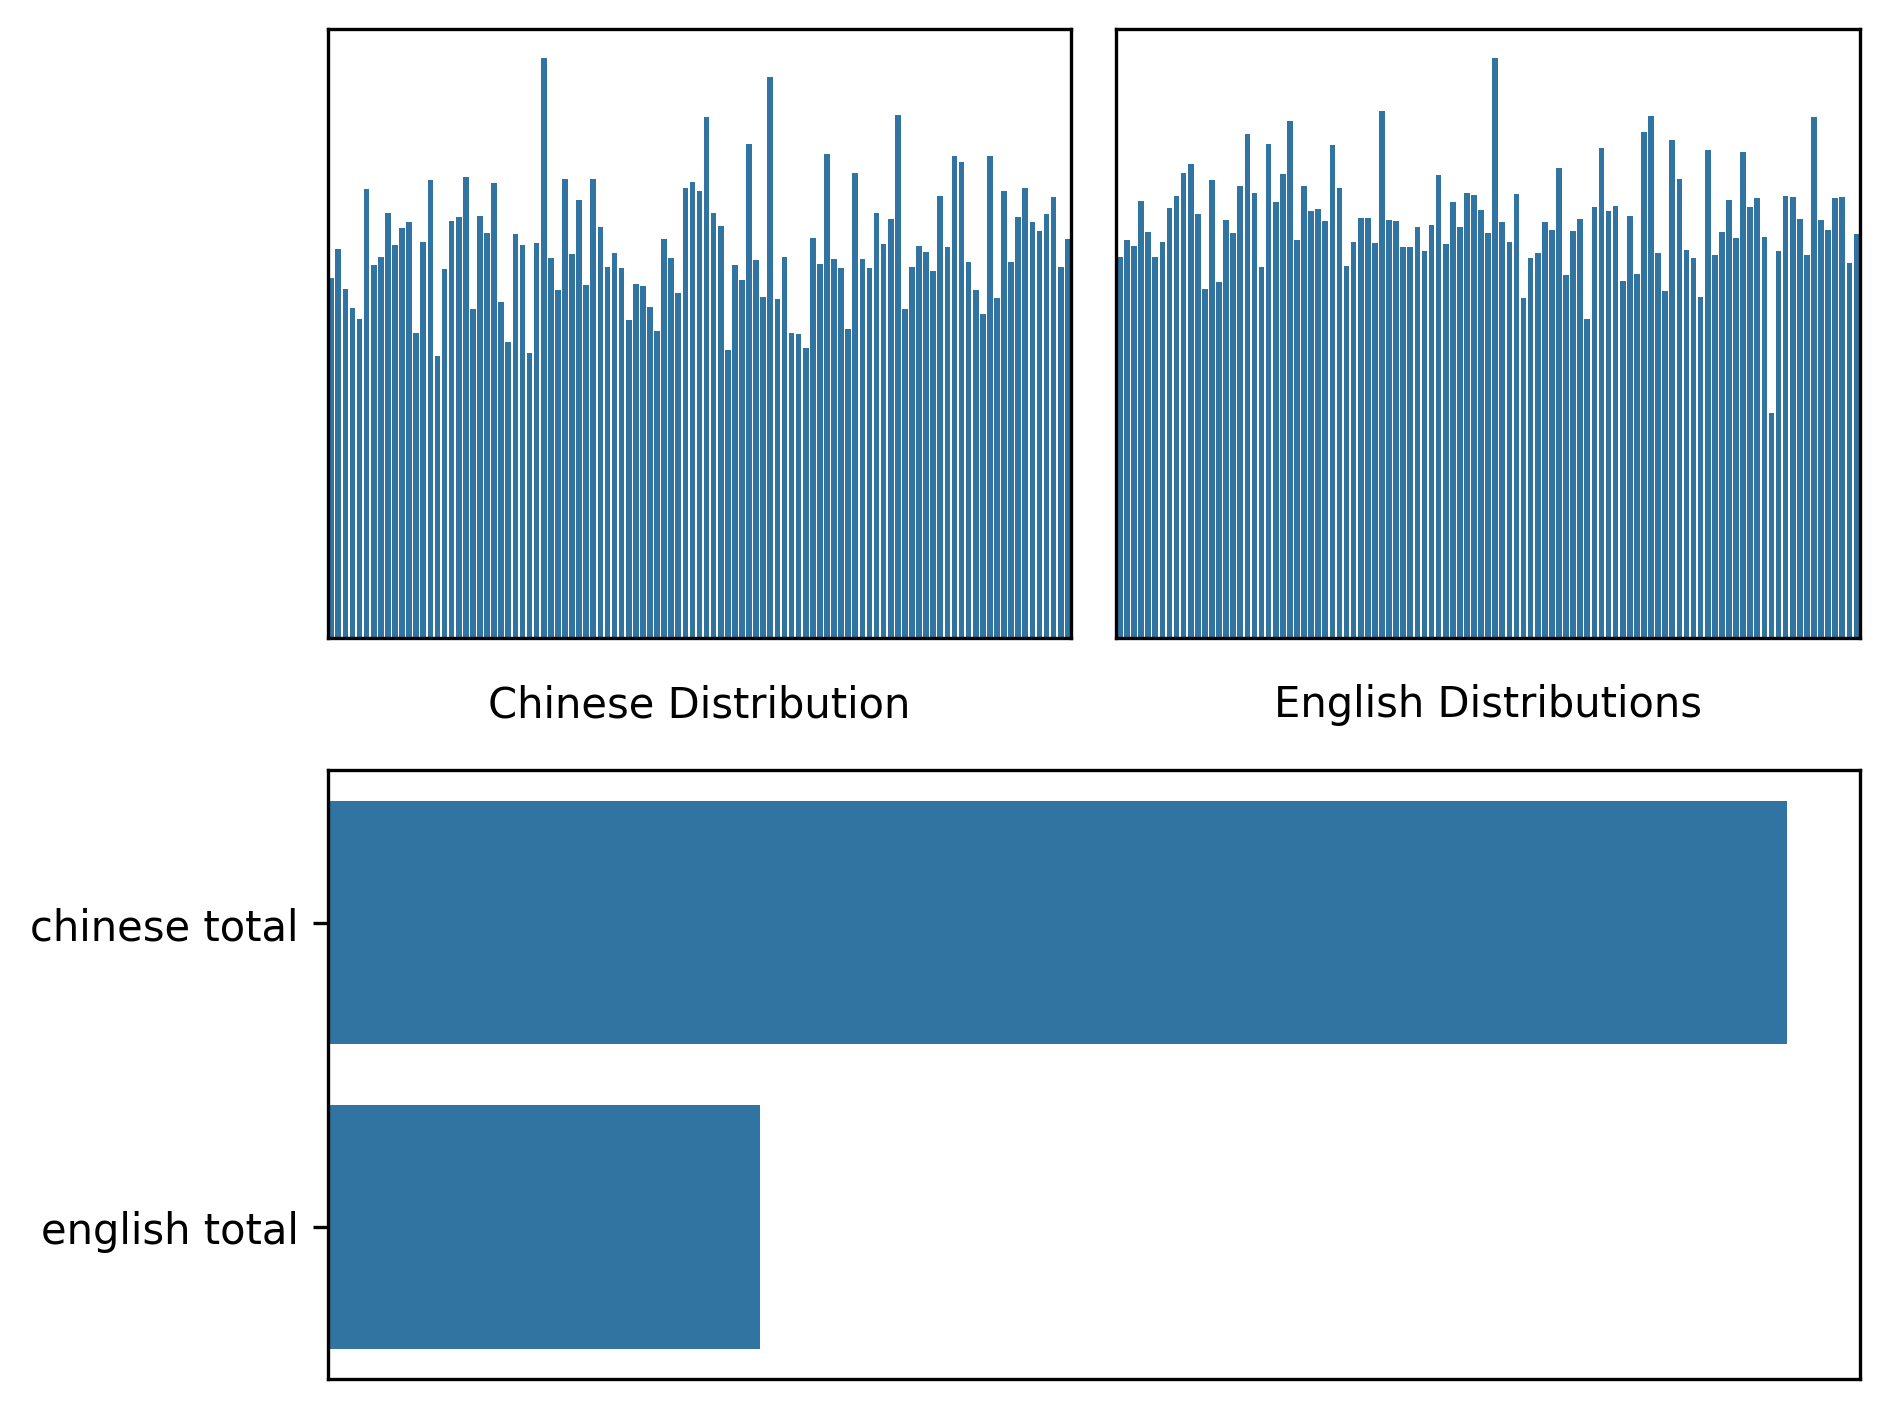

In [13]:
#plt.title("Class Distributions in Chinese and English Vs. Script Distributions")

ax1 = plt.subplot(2, 2, 1)
plot_distributions(ax1, counts_cn, "Chinese Distribution")
ax2 = plt.subplot(2, 2, 2)
plot_distributions(ax2, counts_en, "English Distributions")


cn_total = counts_cn.sum()
en_total = counts_en.sum()

big_ax = plt.subplot(212)
sns.barplot(data = {"chinese total":cn_total, "english total":en_total}, orient='h', ax=big_ax)
big_ax.set_xticklabels([])
big_ax.set_xticks([])
plt.tight_layout()
plt.show()



### Simple Graph Segmentation Visualization

In [14]:
import cv2 as cv
from skimage.morphology import skeletonize
import networkx as nx

#module for converting skeleton networks into a graph representation
import sknw

from qdanalysis.preprocessing import preprocess

In [15]:
eng_test = cv.imread(r'CERUG_EN_Test.png')
eng_test_gs, eng_test_bin = preprocess(eng_test)
eng_test_skele = skeletonize(eng_test_bin)

In [16]:
#going to assume a preprocesed image is fed in
def segment_stroke_fragments(image):
    labels = np.zeros_like(image, dtype=int)

    #can't decide if I should pass in the graph or do it in the function like this
    graph = sknw.build_sknw(image, multi=True, full=False, ring=True)

    #TODO: figure out a way to vectorize the outer portion
    for label_idx, (node1, node2, idx) in enumerate(graph.edges):
        edge_points = graph[node1][node2][idx]['pts']

        labels[edge_points[:, 0], edge_points[:, 1]] = label_idx + 1 #need to account for zero indexing
    
    return labels, graph

eng_test_skele_labeled, graph = segment_stroke_fragments(eng_test_skele)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
label_coords = np.array(eng_test_skele_labeled.nonzero()).T
labels = eng_test_skele_labeled[label_coords[:, 0], label_coords[:, 1]] #not sure if actually required

In [19]:
cls = KNeighborsClassifier(n_neighbors=3)
cls.fit(label_coords, labels)

KNeighborsClassifier(n_neighbors=3)

In [20]:
img_coords = np.array(eng_test_bin.nonzero()).T
img_labels = cls.predict(img_coords)
img_labels

array([ 1,  1,  1, ..., 52, 52, 52])

In [21]:
labeled_image = np.zeros_like(eng_test_gs, dtype=int)
labeled_image[img_coords[:, 0], img_coords[:, 1]] = img_labels

Text(0.5, 0.9, 'Simple Graph Segmentation Method')

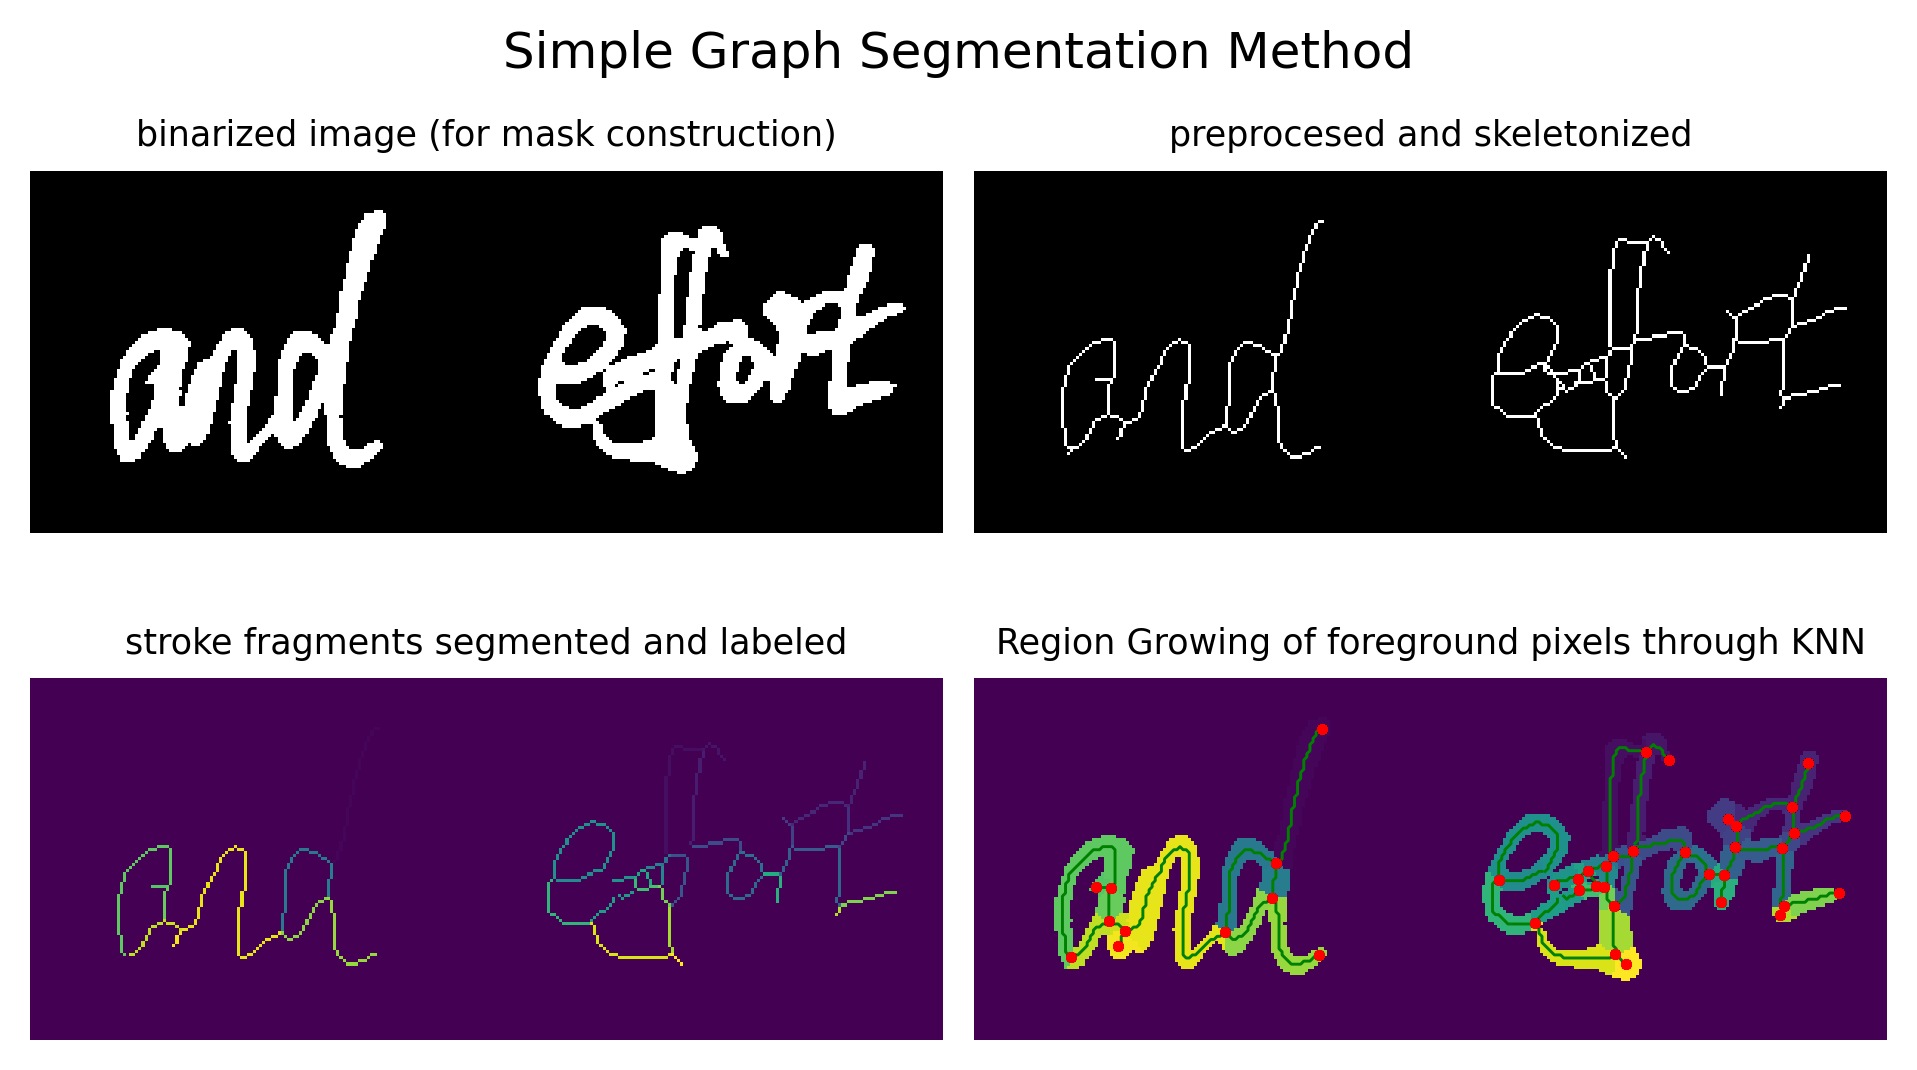

In [44]:
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['font.size'] = 7

#figure for presentation
fig, axes = plt.subplots(2, 2)

#original image
#eng_test_orig = cv.imread("CERUG_EN_Test.png")
axes[0, 0].imshow(eng_test_bin, cmap='gray')
axes[0, 0].set_title("binarized image (for mask construction)")
axes[0, 0].axis("off")

#preprocessed
axes[0, 1].imshow(eng_test_skele, cmap='gray')
axes[0, 1].set_title("preprocesed and skeletonized")
axes[0, 1].axis("off")

#graph representation
axes[1, 0].imshow(eng_test_skele_labeled, interpolation="nearest")
axes[1, 0].set_title("stroke fragments segmented and labeled")
axes[1, 0].axis("off")

# region growing?
axes[1, 1].imshow(labeled_image, interpolation="nearest")
axes[1, 1].set_title("Region Growing of foreground pixels through KNN")
axes[1, 1].axis("off")

# draw edges by pts
for (s, e_dict, idx) in graph.edges: 
        ps = graph[s][e_dict][idx]['pts']
        plt.plot(ps[:, 1], ps[:, 0], 'green', linewidth=.7)
#plot nodes of graph
for (start, end) in graph.edges():
    nodes = graph.nodes()
    ps = np.array([nodes[i]['o'] for i in nodes])
    axes[1, 1].plot(ps[:, 1], ps[:, 0], 'r.', markersize=3)

padding = 0.01
fig.subplots_adjust(wspace=padding, hspace=-.5)
fig.tight_layout()
fig.suptitle("Simple Graph Segmentation Method", y=.9, fontsize=12)
